In [6]:
# lets start by importing libraries and loading data from kaggle directly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


In [8]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [10]:
df.columns.to_list()

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [30]:
# model and accuracy metrics with cross validations

import lightgbm as lgb

from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold

In [33]:
# deining a function that gives me train data

def process_data(df):
  df['ever_married'] = df['ever_married'].replace({'Yes': True, 'No': False})
  categorical_columns = [
      'gender',
      'work_type',
      'Residence_type',
      'smoking_status',
  ] # Enhanced Readability: Converting columns to their appropriate data types improves the readability, Compatibility with Libraries: Certain libraries and functions may expect or require specific data types,
  df[categorical_columns] = df[categorical_columns].astype("category") # acha why we are doing this Memory Efficiency: Categorical data types are more memory efficient than object or string data types,Performance Optimization: Some operations, such as groupby and pivot_table, can be faster
# Better Support for Analysis: Categorical data types allow for better support in data analysis tasks such as visualization, summary statistics, and machine learning algorithms
  df['doctor'] = np.random.randint(0,8, size = len(df))

  return df

# Holdout set is the future data that we are considering it as a future data to see our model to predict more like a validation set
train, holdout = process_data(df).sample(frac=1, random_state=529).sort_values("doctor").reset_index(drop=True), df.sample(random_state=529).sort_values("doctor").reset_index(drop=True)

In [34]:
train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,56543,Female,70.00,0,0,True,Private,Rural,69.04,35.9,formerly smoked,0,0
1,9648,Female,71.00,0,1,True,Private,Urban,170.95,35.2,never smoked,0,0
2,24669,Female,77.00,0,1,True,Private,Rural,231.56,36.9,never smoked,1,0
3,3701,Female,2.00,0,0,False,children,Urban,84.12,15.3,Unknown,0,0
4,2860,Male,55.00,0,0,True,Private,Rural,82.88,29.4,Unknown,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,3640,Female,31.00,0,0,False,Self-employed,Rural,70.65,29.9,Unknown,0,7
5106,2982,Female,57.00,1,0,True,Private,Rural,235.85,40.1,never smoked,0,7
5107,68003,Male,46.00,1,0,True,Private,Rural,73.72,NaN,smokes,0,7
5108,20399,Female,72.00,1,0,True,Private,Urban,105.51,32.7,never smoked,0,7


In [35]:
train.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'doctor'],
      dtype='object')

In [36]:
def get_X_y(train):
    features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
          'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
          'smoking_status', ]

    groups = 'doctor'
    target = 'stroke'

    X = train[features]
    y = train[target]
    groups = train[groups]

    return X,y,groups

In [37]:
X,y,groups = get_X_y(train)

In [38]:
# building machine learning model
clf = lgb.LGBMClassifier(n_estimators = 100)
clf.fit(X,y)

[LightGBM] [Info] Number of positive: 249, number of negative: 4861
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 5110, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048728 -> initscore=-2.971547
[LightGBM] [Info] Start training from score -2.971547


LGBMClassifier()

In [39]:
pred = clf.predict(X)
pred_prob = clf.predict_proba(X)[:, 1] #  Once the probabilities are predicted, [:, 1] is used to select the probabilities for only the positive class.
pred_prob

array([1.10392211e-02, 4.15368817e-02, 7.15785325e-01, ...,
       5.25417337e-03, 4.05873972e-02, 3.02677109e-05])

In [40]:
# now scoring the accuracy

acc_score = accuracy_score(y, pred)
auc_score = roc_auc_score(y, pred_prob)

print(f'The score of training set accuracy: {acc_score:0.4f} , and AUC of  {auc_score: 0.4f}')

The score of training set accuracy: 0.9886 , and AUC of   0.9996


In [41]:
# wow the model is giving good accuracy score on the train

# now lets see on the validation data/ holdout data that we kept

In [46]:
X_holdout, y_holdout, groups_holdout = get_X_y(holdout)

pred = clf.predict(X_holdout)
pred_prob = clf.predict_proba(X_holdout)[:, 1]
acc_score = accuracy_score(y_holdout, pred)
# auc_score = roc_auc_score(y_holdout, pred_prob)
print(
    f"Our accuracy on the holdout set is {acc_score:0.4f} and AUC is {auc_score:0.4f}"
)

Our accuracy on the holdout set is 1.0000 and AUC is 0.9996


In [ ]:
# lol way too much implanced dataset

In [48]:
X, y, groups = get_X_y(train)

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.1)
clf = lgb.LGBMClassifier(n_estimators=100, max_depth=3)
clf.fit(X_tr, y_tr)
pred = clf.predict(X_val)
pred_prob = clf.predict_proba(X_val)[:, 1]
acc_score = accuracy_score(y_val, pred)
auc_score = roc_auc_score(y_val, pred_prob)
print(
    f"Our accuracy on the validation set is {acc_score:0.4f} and AUC is {auc_score:0.4f}"
)

[LightGBM] [Info] Number of positive: 223, number of negative: 4376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 4599, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048489 -> initscore=-2.976719
[LightGBM] [Info] Start training from score -2.976719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [49]:
# baseline

# lets go do all predicting zeros

In [52]:
accuracy_score(y, np.zeros_like(y)), roc_auc_score(y, np.zeros_like(y)) # observation the model we preducted earlier it is supposed to give use more than 95.12 accuracy as it is base line below which is considered as worst model

(0.9512720156555773, 0.5)

In [53]:
# now lets do cross validation

In [55]:
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

In [59]:
def visualize_groups(classes, groups, name):
    fig, ax = plt.subplots()
    ax.scatter(range(len(groups)), [0.5] * len(groups), c=groups, marker="_", lw=50, cmap=cmap_data)
    ax.scatter(range(len(groups)), [3.5] * len(groups), c=classes, marker="_", lw=50, cmap=cmap_data)
    ax.set(ylim=[-1, 5], yticks=[0.5, 3.5], yticklabels=["Data\ngroup", "Data\nclass"], xlabel="Sample index")

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        ax.scatter(range(len(indices)), [ii + 0.5] * len(indices), c=indices, marker="_", lw=lw, cmap=cmap_cv, vmin=-0.2, vmax=1.2)

    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data)
    ax.scatter(range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data)

    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(yticks=np.arange(n_splits + 2) + 0.5, yticklabels=yticklabels, xlabel="Sample index", ylabel="CV iteration", ylim=[n_splits + 2.2, -0.2], xlim=[0, 100])
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend([Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))], ["Testing set", "Training set"], loc=(1.02, 0.8))
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()

def get_fake_X_y():
    n_points = 100
    X_ = np.random.randn(100, 10)
    percentiles_classes = [0.1, 0.9]
    y_ = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])
    groups_ = np.hstack([[ii] * 10 for ii in range(10)])
    return X_, y_, groups_


In [60]:
# Generate fake data
X, y, groups = get_fake_X_y()

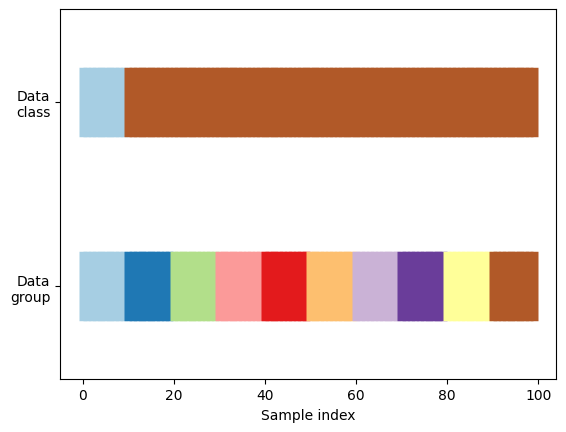

In [61]:
# Visualize groups and classes
visualize_groups(y, groups, "Dataset")

In [ ]:
## KFold
# Split dataset into k consecutive folds (without shuffling by default).

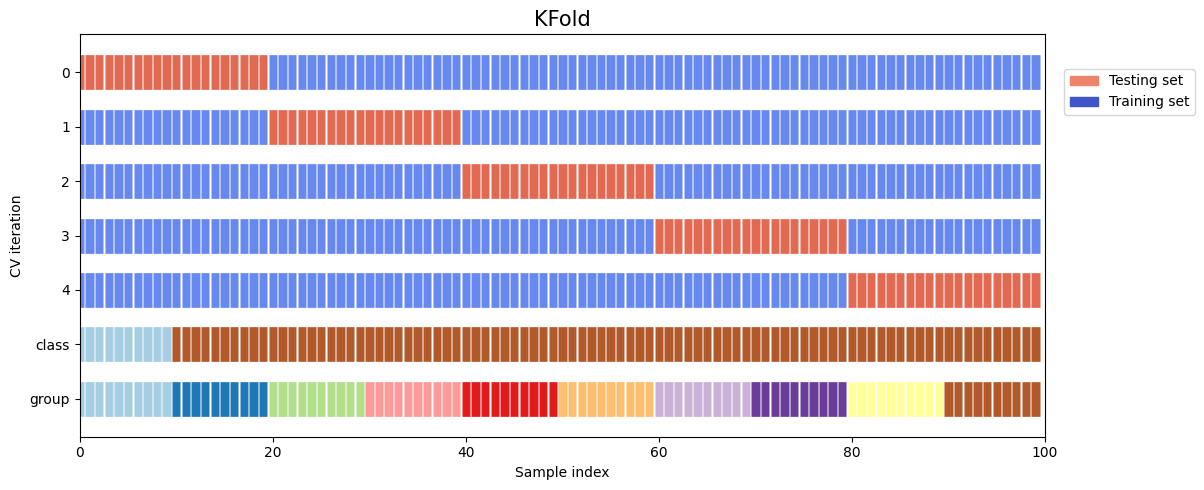

In [63]:
kf = KFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(KFold, X_, y_, groups_)

In [ ]:
## Stratified KFold¶
# KFold but the folds are made by preserving the percentage of samples for each class.

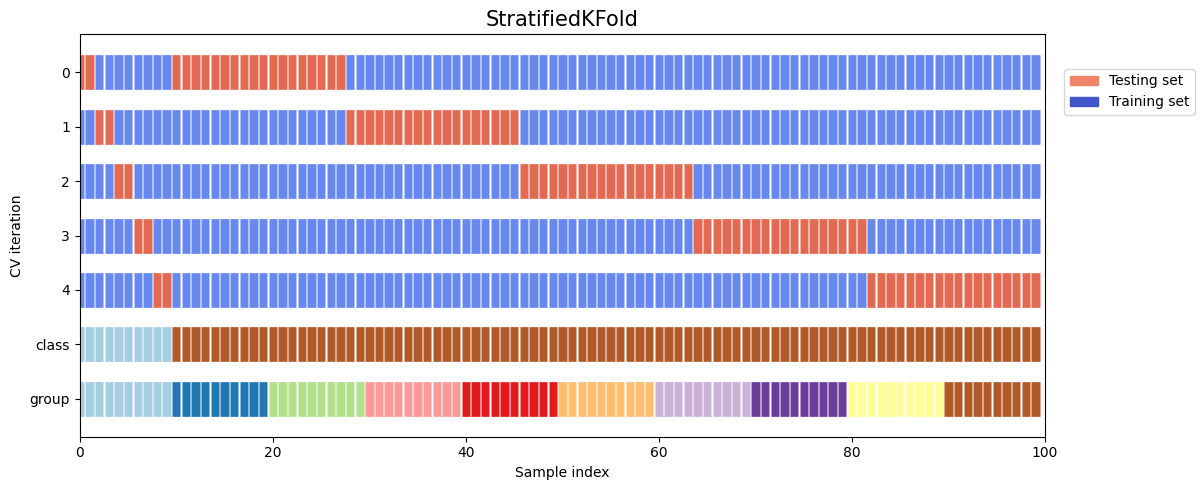

In [62]:
# Plot cross-validation results
plot_cv(StratifiedKFold, X, y, groups)

In [ ]:
## Group KFold
# The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

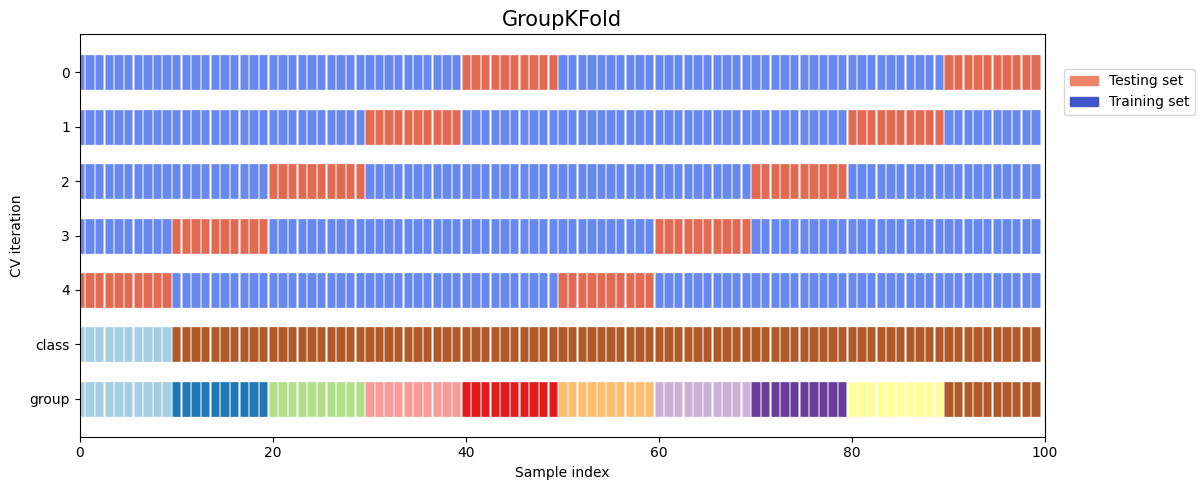

In [64]:
gkf = GroupKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(GroupKFold, X_, y_, groups_)

In [ ]:
## Stratified Group KFold
# The difference between GroupKFold and StratifiedGroupKFold is that the former attempts to create balanced folds such that the number of distinct groups is approximately the same in each fold,
# whereas StratifiedGroupKFold attempts to create folds which preserve the percentage of samples for each class as much as possible given the constraint of non-overlapping groups between splits.

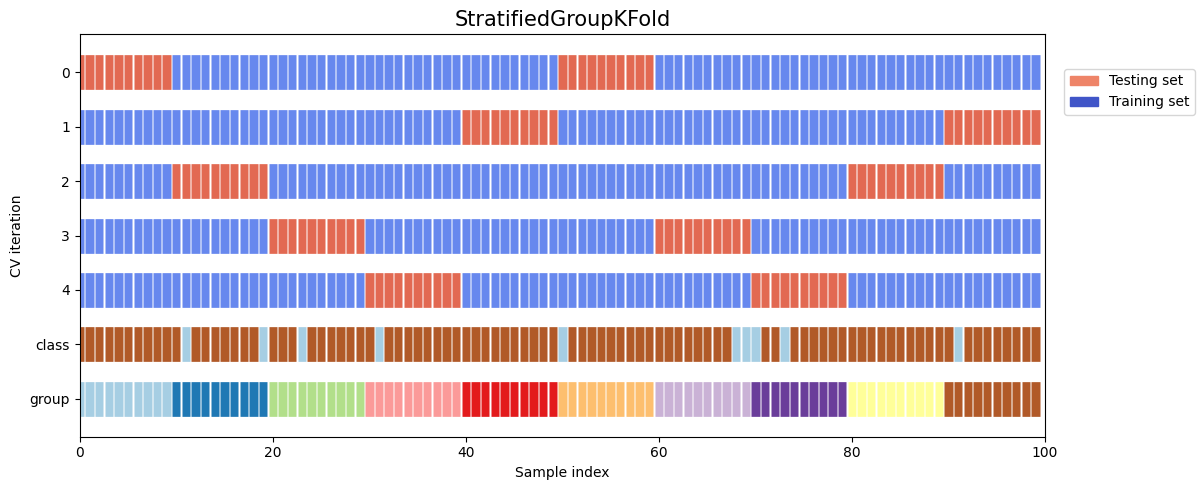

In [66]:
gskf = StratifiedGroupKFold()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

Time Series Split

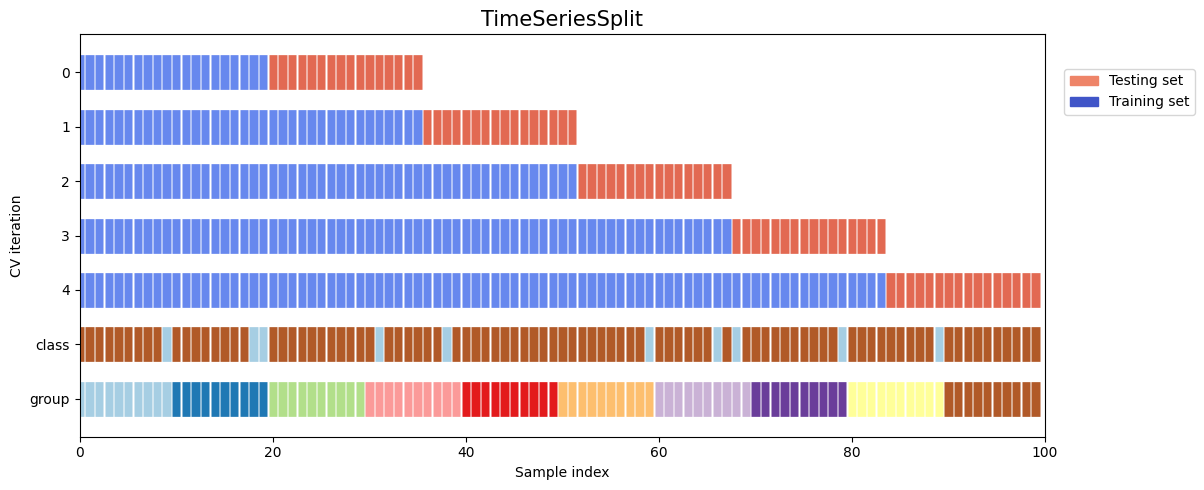

In [67]:
tss = TimeSeriesSplit()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(TimeSeriesSplit, X_, y_, groups_)

Our Example Using Proper Cross Validation

1. Small/imblanced -> Stratified
2. Group
3. Shuffle in on
--> StratifiedGroupKFold is a good choice for this situation.

In [68]:
sgk = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=529)

X, y, groups = get_X_y(train)

fold = 0
aucs = []
for train_idx, val_idx in sgk.split(X, y, groups):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]

    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    clf = lgb.LGBMClassifier(n_estimators=100)
    clf.fit(X_tr, y_tr)
    pred = clf.predict(X_val)
    pred_prob = clf.predict_proba(X_val)[:, 1]
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    print(f"======= Fold {fold} ========")
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f} and AUC is {auc_score:0.4f}"
    )
    fold += 1
    aucs.append(auc_score)
oof_auc = np.mean(aucs)
print(f'Our out of fold AUC score is {oof_auc:0.4f}')

[LightGBM] [Info] Number of positive: 181, number of negative: 3649
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 3830, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.047258 -> initscore=-3.003711
[LightGBM] [Info] Start training from score -3.003711
======= Fold 0 ========
Our accuracy on the validation set is 0.9398 and AUC is 0.8028
[LightGBM] [Info] Number of positive: 180, number of negative: 3599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 3779, number of used features: 10
[Ligh